# Analisy results MOA mini-batching optimized preliminary

The results compareds this work use follow variables.

Frequencies in MHz:

    - Minimum: 600Mhz, Maximum: 1200Mhz

Size mini-batching uses are:

    ..

All executions are used ensemble size 25.

...

In [4]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [7]:
def add_label_column_df(df):
    for index, row in df.iterrows():
        _str = row["algorithm"]

        if "RUNPER" in _str and row["batch_size"] == 1:
            df.at[index, 'label'] = "Parallel"
        elif row["batch_size"] == 1:
            df.at[index, 'label'] = "Seq"
        else:
            df.at[index, 'label'] = int(row["batch_size"])
    

    df = df.drop(df[df.label == 5].index)
    df = df.drop(df[df.label == 15].index)

    return df

In [8]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [9]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [10]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [11]:
import natsort

#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    df.iloc[natsort.index_humansorted([df.label, df.batch_size])]

    labels = df.label
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
    ax.plot(x, pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x, pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [12]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(12,12), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(by=['batch_size']), alg)
           # df_aux = df_aux.sort_values(by=['label'], ascending=True)
            #if tables:
                #display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Algorithm Methodology')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [13]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/optimized/08-07-2022/results/4/first"
wantedCSVfilename = "data-batch-vs-acc-600-1200-first.csv"

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


In [14]:
resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = add_label_column_df(df)

/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_96865/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_96865/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_96865/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_96865/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

,dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change,label
0,elecNormNew,OBASHTRUNPER,25,4,1,1,"45,312.00",35.64,83.36,83.12,82.67,Parallel
1,covtypeNorm,OBMB,25,4,250,1,"581,012.00",160.86,77.11,73.02,55.07,250
2,airlines,OBMB,25,4,75,1,"539,383.00",95.07,60.42,61.29,57.19,75
3,covtypeNorm,SRPRUNPER,25,4,1,1,"63,110.00",530.20,93.11,87.48,87.41,Parallel
4,elecNormNew,OBMB,25,4,50,1,"45,312.00",10.76,76.22,78.52,73.38,50
5,airlines,OBMB,25,4,50,1,"539,383.00",102.51,60.83,60.09,59.59,50
6,covtypeNorm,OBMB,25,4,2000,1,"581,012.00",163.06,77.42,72.32,53.23,2000
7,GMSC,SRPSequential,25,1,1,1,"36,120.00",122.38,93.50,76.70,51.90,Seq
8,elecNormNew,LBagSequential,25,1,1,1,"45,312.00",87.37,89.85,89.85,89.31,Seq
9,elecNormNew,OBMB,25,4,75,1,"45,312.00",10.73,78.47,79.08,76.64,75


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


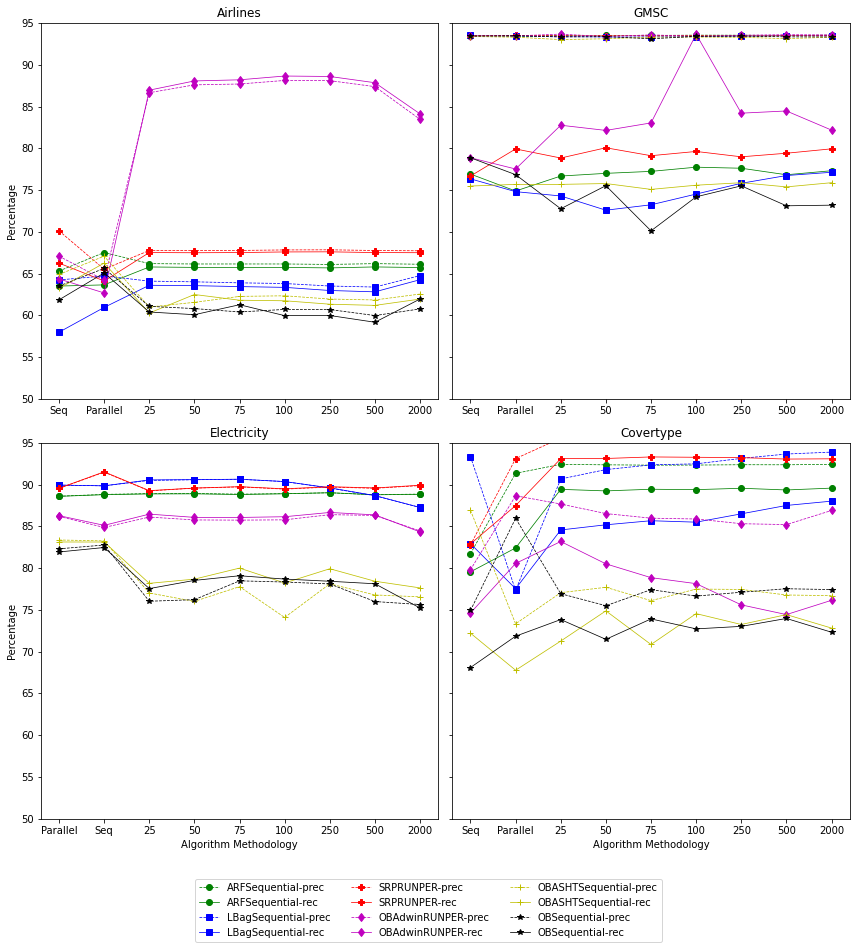

In [15]:
#false makes the chart without markers
display(df)
gen_chart(df)

# Consumer Energy 


In [16]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/optimized/socket/18-07-2022/'

In [72]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [18]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate', 'acc']]

# Read Energy Data

In [73]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [74]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                #print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [75]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [76]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH Logs

In [77]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# Showing and preparing for charts

In [24]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [90]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [91]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.10
    alg_order = ['B25', 'B50', 'B75', 'B100', 'B250', 'B500', 'B2000']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', (0, (3, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 7
    for i in range(versions):
        adf = df.iloc[i]
        values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [114]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#             display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
       
        # debug print, if it shows it is wrong
        # if len(showdf) != 5:
        #     display(showdf)

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [80]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, freq='600', tput=False):
    ps = f'{freq}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

# Run methods to obtained visible results

In [81]:
def read_data_create_final_dataframe(freq, DEBUG=False):
    d = {}
    global header_printed
    header_printed = False
    folder_path = f"{PATH_TO_RESULTS}first/{freq['minimum']}/{freq['maximum']}"
    min = freq['minimum']
    max = freq['maximum']
    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-{max}-freq-min-{min}.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    
    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}tdf-{min}x{max}.csv")    
    return tdf

In [82]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df.batch_size.unique()
    return df

In [108]:
freqs = [{'minimum': '600', 'maximum': '1200'}]
dataframes = []
for f in freqs:
    dataframes.append(read_data_create_final_dataframe(f, True))

moaDF: 420    mdf: 420     sshDF: 420





----------------- {'minimum': '600', 'maximum': '1200'} -----------------


'airlines'

'GMSC'

'elecNormNew'

'covtypeNorm'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


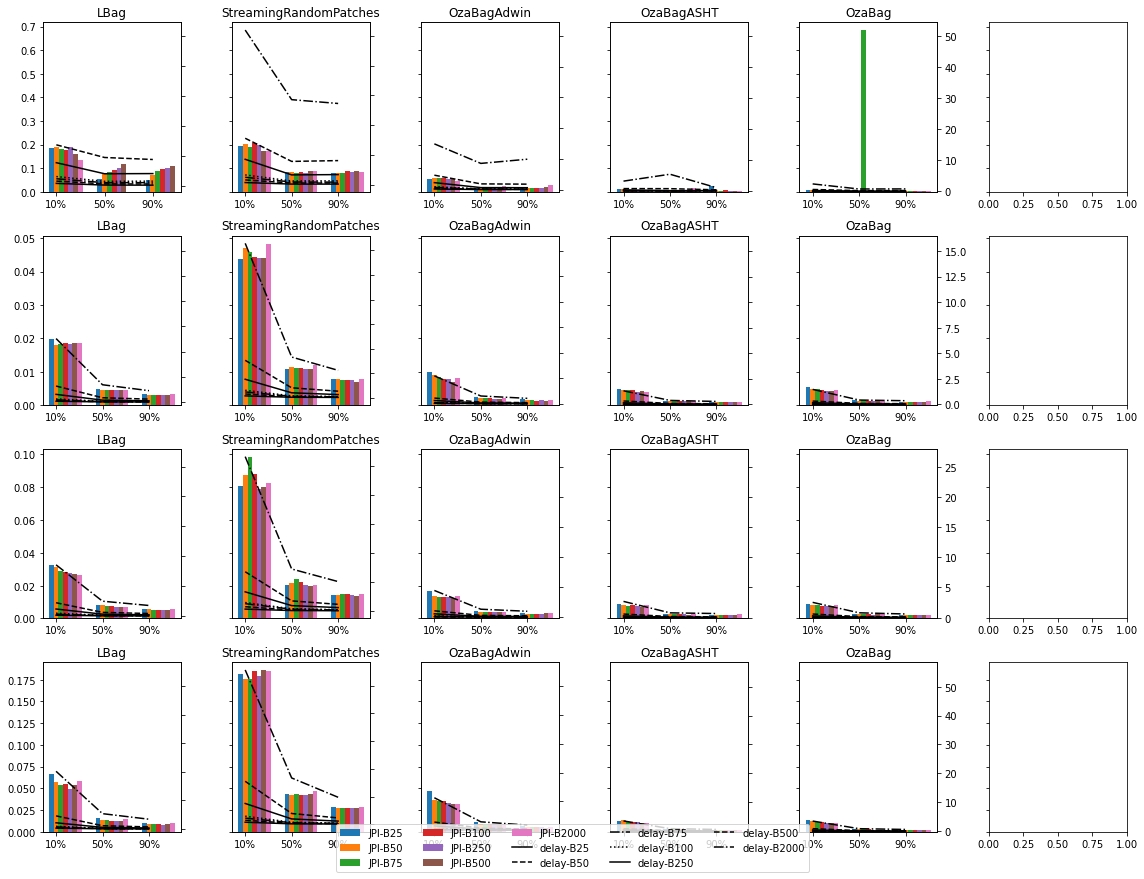

In [115]:
for f,df in zip(freqs, dataframes):
    print(f'\n\n\n----------------- {f} -----------------')
    df = select_columns_and_rename_values_basic(df)
    gen_graph(df, bars=True, freq=f"{f['minimum']}x{f['maximum']}")

Grafico JPI X Delay

# Average Consumer By Frequency

Este é o consumo médio em Joules gasto pela aplicação durante toda sua execução

# Compare Accuracy and IPS

- The IPS has some ligation when accuracy?
- IPS is minor when is frequency is minimum?
- IPS is major when is frequency is maximum?
- IPS is major when utilized mini-batching?

In [116]:
def plot(ax, dsdf, my_id, x):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    c1 = 'tab:red'
    c2 = 'tab:blue'
    c3 = 'tab:green'
    ds = list(dsdf.dataset)[0]
    ax.set_title(f'{dsformalname[ds]}')
    ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='Acuraccy')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.batch_size)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax3 = ax.twinx()
    ax3.plot(x, pd.to_numeric(dsdf.JPI), color=c3, label='JPI')
    ax3.tick_params(axis='y', labelcolor=c3)
    ax3.spines["right"].set_position(("axes", 1.14))
    ax3.set_label('JPI')
    if int(my_id/2) == 1:
        ax.set_xlabel('Batch size')
        ax.legend(loc='upper center', bbox_to_anchor=(0, -0.20), fancybox=True, shadow=True, ncol=5)
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=5)
        ax3.legend(loc='upper center', bbox_to_anchor=(1, -0.20), fancybox=True, shadow=True, ncol=5)

In [124]:
def new_plot(ax, dsdf, my_id, x, fig):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype', 'kyoto_binary': 'Kyoto'}
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm', 'kyoto_binary']
    global twin1
    global twin2
    c1 = 'tab:red'
    c2 = 'tab:blue'
    c3 = 'tab:green'
    ds = list(dsdf.dataset)[0]
    ax.set_title(f'{dsformalname[ds]}')
    ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='Acuraccy')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.batch_size)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax3 = ax.twinx()
    ax3.plot(x, pd.to_numeric(dsdf.JPI), color=c3, label='JPI')
    ax3.tick_params(axis='y', labelcolor=c3)
    ax3.spines["right"].set_position(("axes", 1.14))
    ax3.set_label('JPI')
    if int(my_id/2) == 1:
        ax.set_xlabel('Batch size')
        ax.legend(loc='upper center', bbox_to_anchor=(0, -0.20), fancybox=True, shadow=True, ncol=5)
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=5)
        ax3.legend(loc='upper center', bbox_to_anchor=(1, -0.20), fancybox=True, shadow=True, ncol=5)


In [123]:
def gen_graph_initial_peralg_joules(df, display_df=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    algorithms = ['LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
#     algorithms = ['LBag']
    alg_formal_name = {'ARF': 'AdaptiveRandomForest', 'LBag': 'LeveragingBag', 'SRP':'StreamingRandomPatches', 
                                                'OBAdwin':'OzaBagAdwin', 'OBASHT':'OzaBagASHT', 'OB':'OzaBag'}
    global twin1
    global twin2
    if display_df:
        display(df)
    df = select_columns_and_rename_values(df)
    if display_df:
        display(df)
    for alg in algorithms:
        filename = f"{alg}-sizeVS3"
        fig, axs = plt.subplots(3, 2, figsize=(10,8))
        twin1 = twin2 = axs[0][0]
        axs[2][1].set_visible(False)
        dfalg = filter_by_substring_algorithm(df, alg)
        if display_df:
            display(dfalg)
#         fig.suptitle(f'{alg_formal_name[alg]}')
        for ds in datasets:
#             display(dfalg)
            dsdf = dfalg[(dfalg.dataset == ds)]
            x = np.arange(len(dsdf.ensemble_size))
            if display_df:
                if alg == 'SRP':
                    display(dsdf)
            my_id = datasets.index(ds)
            if my_id == 4:
                pass
            ax = axs[int(my_id/2)][my_id%2]
            new_plot(ax, dsdf, my_id, x, fig)

        fig.tight_layout(pad=0.5)
#         print('pos:', axs[2][0].get_position(), '\nanchor:',axs[2][0].get_anchor())
        x0=0.05081018518518519
        y0=0.03703703703703709
        x1=0.4019981060606061
        y1=0.28742283950617287
        axs[2][0].set_position([x0+0.25, y0, x1-x0, y1-y0])
#         plt.savefig(f'{filename}.eps', bbox_inches='tight')
        
        
        lines_1, labels_1 = axs[0][0].get_legend_handles_labels()
        lines_2, labels_2 = twin1.get_legend_handles_labels()
        lines_3, labels_3 = twin2.get_legend_handles_labels()
        lines = lines_1 + lines_2 + lines_3
        labels = labels_1 + labels_2 + labels_3
        lgd = fig.legend(lines, labels, loc=3, ncol=1, bbox_to_anchor=(0.05, 0.1), prop={'size': 14})
#         lgd.set_in_layout(True)
#         fig.subplots_adjust(bottom=0.2)
        
        plt.savefig(f'Pi-{filename}.eps', pad_inches=1.5)
        print(filename)
        plt.savefig(f'Pi-{filename}.png', pad_inches=1.5)

In [122]:
def gen_graph_initial_peralg(df, display_df=False, freq=''):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']

    algorithms = ['LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #algorithms = ['OB']
    filename = f"pi-rates"
    for alg in algorithms:
        fig, axs = plt.subplots(2, 2, figsize=(14,9))
        # set the spacing between subplots
        plt.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)
        dfalg = filter_by_substring_algorithm(df, alg)
        fig.suptitle(f'{alg} - Frequency {freq}')
        for ds in datasets:
            dsdf = dfalg[(dfalg.dataset == ds)]
            x = np.arange(len(dsdf.batch_size))
            my_id = datasets.index(ds)
            ax = axs[int(my_id/2)][my_id%2]
            plot(ax, dsdf, my_id, x)
        plt.savefig(f'{filename}.eps', bbox_inches='tight')

In [120]:
def build_and_output_graph(execution='first'):
    freqs = [{'minimum': '600', 'maximum': '1200'}]
    dataframes = []
    
    for f in freqs:
        dataframes.append(read_data_create_final_dataframe(f, True))

    for f,df in zip(freqs, dataframes):
        print(f'\n\n\n----------------- {f} -----------------')
        df = df[df.PERC == '90']
        df = df.loc[:,['dataset','algorithm','batch_size', 'instances', 'time', 'JPI', 'acc']].sort_values(by=['batch_size'])
        df = select_columns_and_rename_values(df)
        df['IPS'] = df['instances'] / df['time']
        df['ensemble_size'] = '25'

        gen_graph_initial_peralg(df, display_df=False)

moaDF: 420    mdf: 420     sshDF: 420



----------------- {'minimum': '600', 'maximum': '1200'} -----------------


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_96865/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_96865/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_96865/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_96865/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

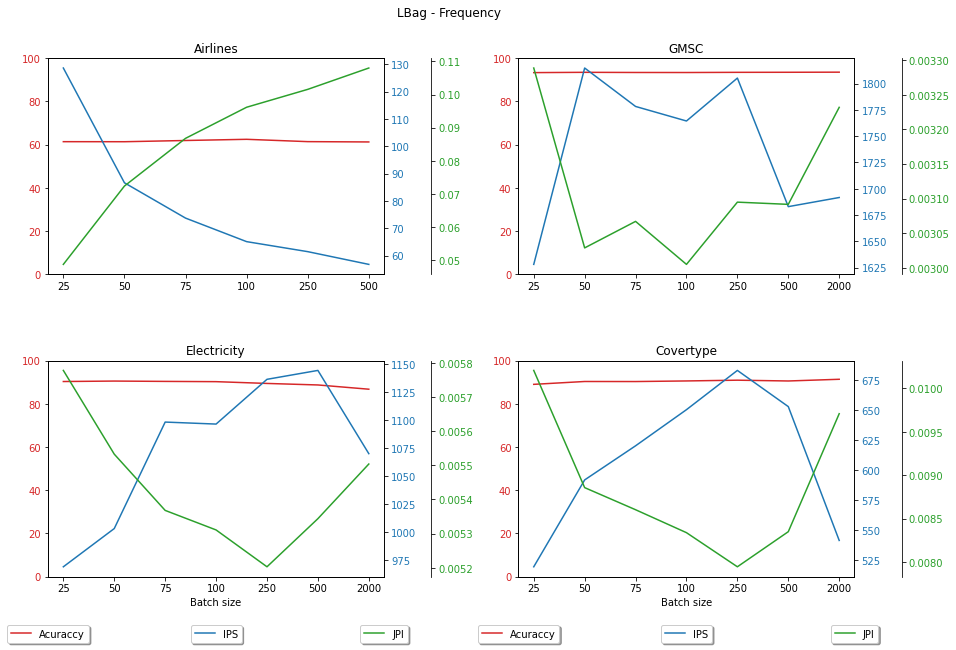

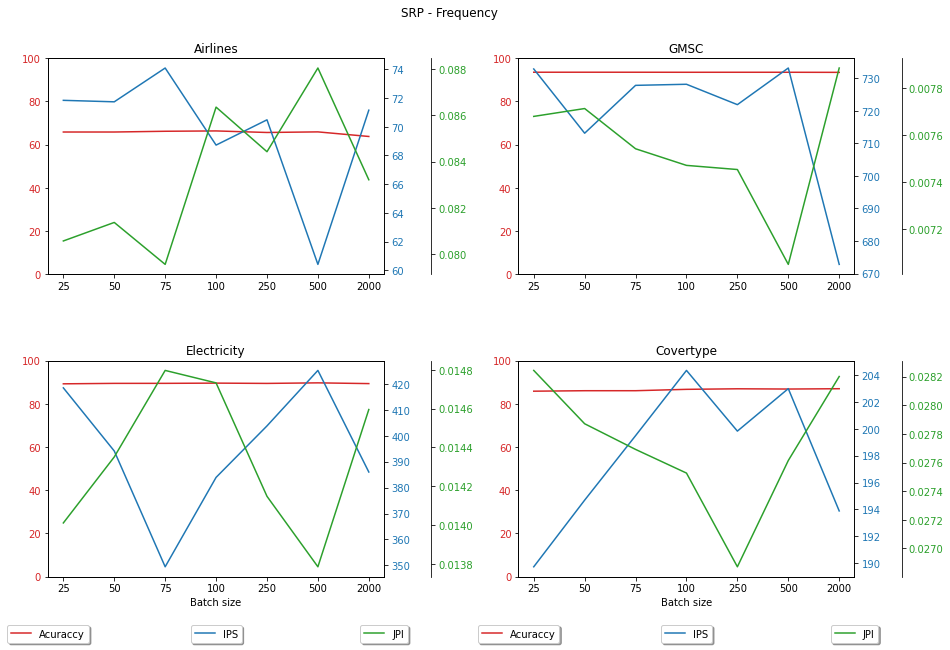

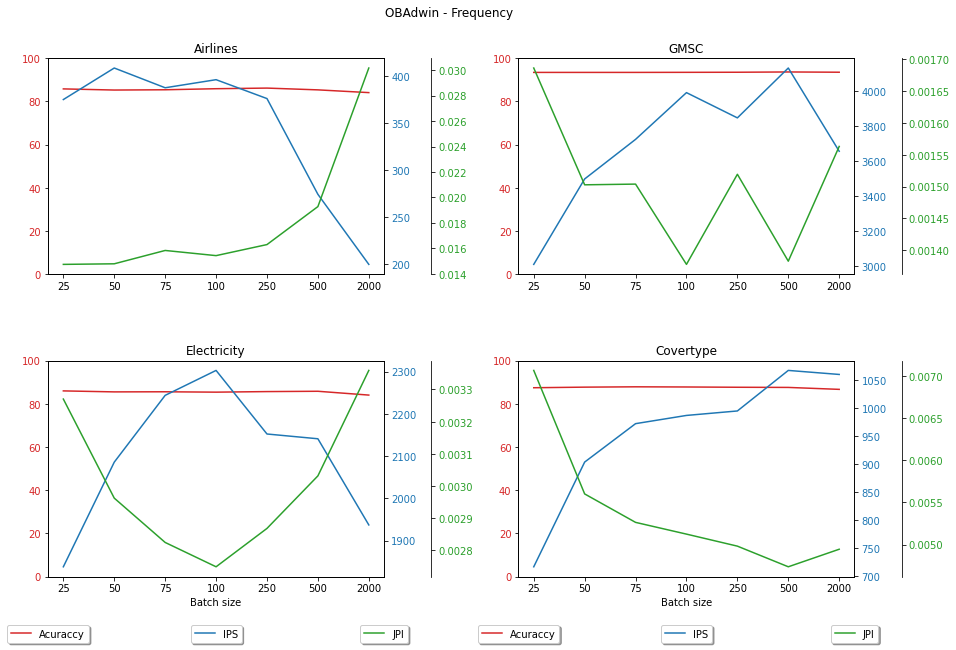

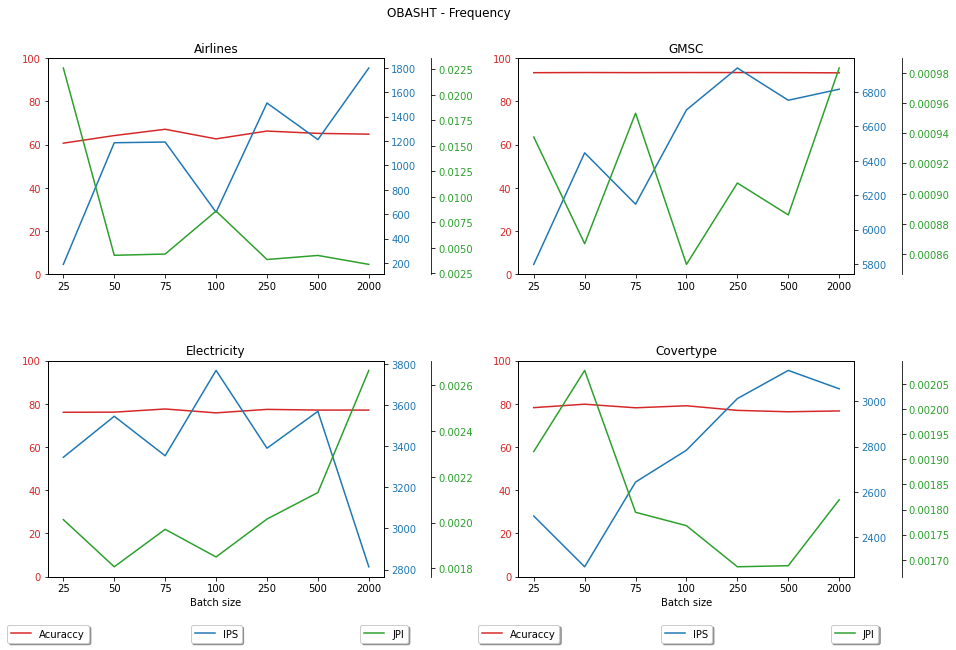

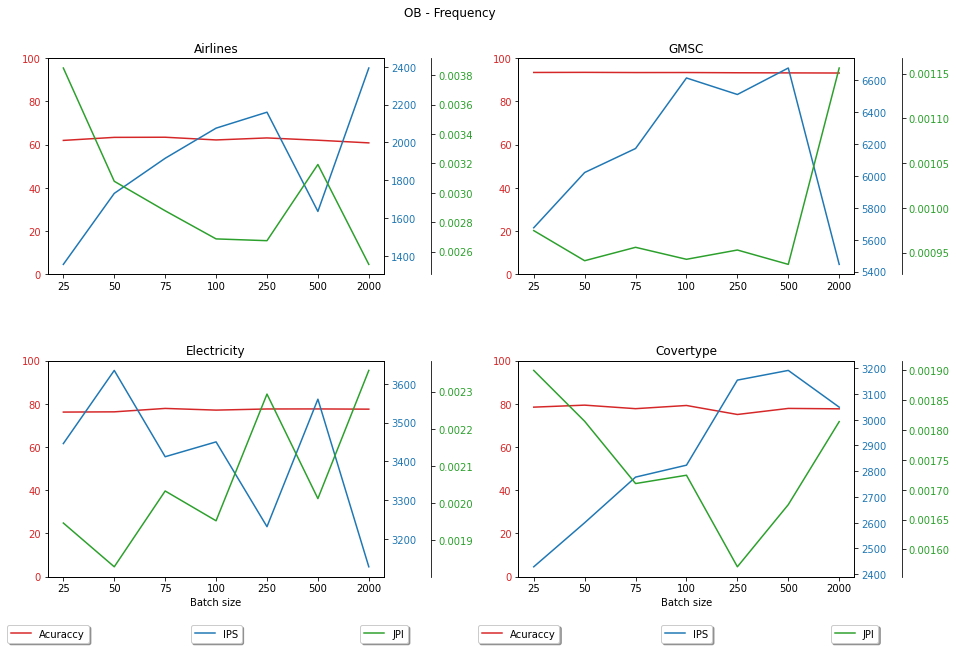

In [125]:
build_and_output_graph('first')

Analise JPI x IPS X ACC ...

# Analisy Speedup

From its here we analisy speedup to the algorithm with loop fusion when compared the sequential version. 

## Hardware used

- machdep.cpu.cores_per_package: 8
- machdep.cpu.core_count: 8
- machdep.cpu.logical_per_package: 8
- machdep.cpu.thread_count: 8
- machdep.cpu.brand_string: Apple M1


In [ ]:
#Folder inside results directory that contains all the MOA dump files for these experiments
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/optimized/speedup/08-07-2022/loop-fusion-all-algorithms-speedup"
wantedCSVfilename = "speedup-pi-loop-fusion"

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


In [ ]:
def parse_speedup(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,acc,prec,recall'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [ ]:
df_airlines_arf = []
df_airlines_oza = []
df_elecnormnew_arf = []
df_elecnormnew_oza = []

for cpu in list([1, 2, 3, 4]):
    resultsFolder = f"{folderMOADumps}/{str(cpu)}/first"
    csvFile = f"parsed_csvs/{wantedCSVfilename}-{str(cpu)}.csv"
    directory = os.fsencode(resultsFolder)
    header_printed = False

    with open(f"{csvFile}", "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                output.write(f"{parse_speedup(f'{os.fsdecode(directory)}/{filename}')}\n")

    df = load_df(f'{csvFile}')

    for index, row in df[['dataset', 'algorithm', 'cores', 'acc', 'time', 'instances']].iterrows():
        if (row['dataset'] == 'airlines' and (row['algorithm'] == 'ARFSequential' or row['algorithm'] == 'ARFMB')):
            if (row['algorithm'] == 'ARFSequential'):
                time_sequential_arf = row['time']
                speedup = 1
                eficiency = 1
            else:
                speedup = time_sequential_arf / row['time']
                eficiency = speedup / row['cores']
            
            df_airlines_arf.append({
                'dataset': row['dataset'],
                'algorithm': row['algorithm'],
                'cores': row['cores'],
                'time': row['time'],
                'instances': row['instances'],
                'speedup': speedup,
                'eficiency': eficiency,
                'acc': row['acc']
            })

        if (row['dataset'] == 'airlines' and (row['algorithm'] == 'OBSequential' or row['algorithm'] == 'OBMB')):
            if (row['algorithm'] == 'OBSequential'):
                time_sequential_ob = row['time']
                speedup = 1
                eficiency = 1
            else:
                speedup = time_sequential_ob / row['time']
                eficiency = speedup / row['cores']

            df_airlines_oza.append({
                'dataset': row['dataset'],
                'algorithm': row['algorithm'],
                'cores': row['cores'],
                'time': row['time'],
                'instances': row['instances'],
                'speedup': speedup,
                'eficiency': eficiency,
                'acc': row['acc']
            })

        if (row['dataset'] == 'elecNormNew' and (row['algorithm'] == 'ARFSequential' or row['algorithm'] == 'ARFMB')):
            if (row['algorithm'] == 'ARFSequential'):
                time_sequential_arf_elec = row['time']
                speedup = 1
                eficiency = 1
            else:
                speedup = time_sequential_arf_elec / row['time']
                eficiency = speedup / row['cores']

            df_elecnormnew_arf.append({
                'dataset': row['dataset'],
                'algorithm': row['algorithm'],
                'cores': row['cores'],
                'time': row['time'],
                'instances': row['instances'],
                'speedup': speedup,
                'eficiency': eficiency,
                'acc': row['acc']
            })

        if (row['dataset'] == 'elecNormNew' and (row['algorithm'] == 'OBSequential' or row['algorithm'] == 'OBMB')):
            if (row['algorithm'] == 'OBSequential'):
                time_sequential_ob_elec = row['time']
                speedup = 1
                eficiency = 1
            else:
                speedup = time_sequential_ob_elec / row['time']
                eficiency = speedup / row['cores']

            df_elecnormnew_oza.append({
                'dataset': row['dataset'],
                'algorithm': row['algorithm'],
                'cores': row['cores'],
                'time': row['time'],
                'instances': row['instances'],
                'speedup': speedup,
                'eficiency': eficiency,
                'acc': row['acc']
            })

df_airlines_arf = pd.DataFrame(df_airlines_arf)
df_airlines_oza = pd.DataFrame(df_airlines_oza)
df_elecnormnew_arf = pd.DataFrame(df_elecnormnew_arf)
df_elecnormnew_oza = pd.DataFrame(df_elecnormnew_oza)
display(df_airlines_oza)

/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_62584/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_62584/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_62584/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_62584/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

,dataset,algorithm,cores,time,instances,speedup,eficiency,acc
0,airlines,OBSequential,1,516.05,"539,383.00",1.00,1.00,64.98
1,airlines,OBMB,2,136.39,"539,383.00",3.78,1.89,60.39
2,airlines,OBMB,3,110.72,"539,383.00",4.66,1.55,60.38
3,airlines,OBMB,4,100.43,"539,383.00",5.14,1.28,62.01


In [ ]:
def add_speedup_and_eficiency_label():
    titles = ["Arlines - ARF", "Arlines - OZA", "ElecNormNew - ARF", "ElecNormNew Oza"]
    i = 0
    for df in [df_airlines_arf, df_airlines_oza, df_elecnormnew_arf, df_elecnormnew_oza]:
        ax = df.plot(kind = 'line', x = 'cores', y = 'speedup', color = 'Blue', linewidth = 3) 
        ax2 = df.plot(kind = 'line', x = 'cores', secondary_y = True, y = 'eficiency', color = 'Green', linewidth = 3, ax = ax) 
        
        plt.title(titles[i]) 
        ax.set_xlabel('Core', color = 'g') 
        ax.set_ylabel('Speedup', color = "b") 
        ax2.set_ylabel('Eficiency', color = 'g')
        plt.tight_layout() 
        plt.show()
        i = i + 1

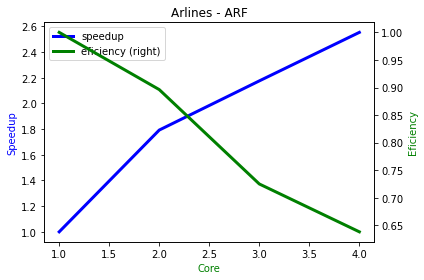

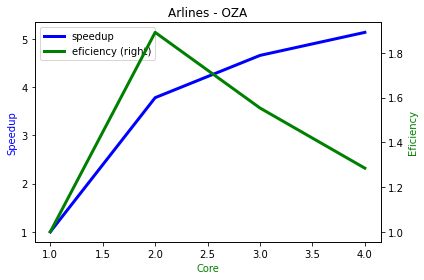

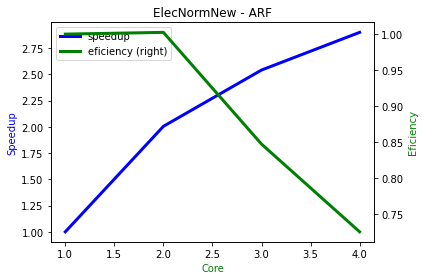

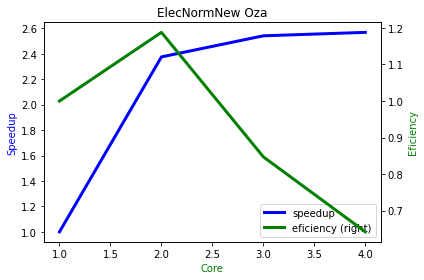

In [ ]:
add_speedup_and_eficiency_label()